In [1]:
import sys
import logging
import multiprocessing as mp

import pymc as pm
import seaborn as sns
import pandas as pd
import numpy as np
import arviz as az
import pytensor.tensor as pt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,LabelBinarizer
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold


In [2]:
# Set working directory
path = './resampled_data/'

In [3]:
X_train = pd.read_csv(path + 'X_train_resampled_80_20.csv')
y_train = pd.read_csv(path + 'y_train_resampled_80_20.csv')
X_test = pd.read_csv(path + 'X_test_80_20.csv')
y_test = pd.read_csv(path + 'y_test_80_20.csv')

In [4]:
assay_info_train = X_train.iloc[:,40:]
X_train = X_train.iloc[:,:40]

ss = StandardScaler()
X_train_o = X_train.copy()
X_train = ss.fit_transform(X_train)
X_train_v, X_validation, y_train_v, y_validation, assay_info_train_v, assay_info_validation = train_test_split(X_train, y_train, assay_info_train, test_size = 0.2, random_state=42)


In [5]:
assay_info_test = X_test.iloc[:,40:]
X_test = X_test.iloc[:,:40]
X_test_o = X_test.copy()
X_test = ss.transform(X_test)

### Model setup needs to be the same before predicting test data

In [6]:
X4_bayes = np.asarray(X_train, dtype="float64")
print(X4_bayes.shape)

factorized_protocols = pd.factorize(assay_info_train.ProtocolName)

Y4_bayes = list(y_train['Outcome'])
coords_simulated = {
    'obs_id': np.arange(X4_bayes.shape[0]),
    'chem_descrip': np.arange(X4_bayes.shape[1]),
    'protocol':list(factorized_protocols[1]),
    'params':['beta_{0}'.format(i) for i in range(X4_bayes.shape[1])]
    }

organisms = pd.factorize(assay_info_train.drop_duplicates().Organism)
tissues_4 = pd.factorize(assay_info_train.drop_duplicates().Tissue_Type4)
tissues_2 = pd.factorize(assay_info_train.drop_duplicates().Tissue_Type2)
gender = pd.factorize(assay_info_train.drop_duplicates().Gender)
cell_type = pd.factorize(assay_info_train.drop_duplicates().Cell_Type)

(57358, 40)


#### Model with only chemical descriptors

In [56]:
print('model setup with only chemical descriptors')
with pm.Model(coords=coords_simulated) as assay_level_model:
    x = pm.Data('x', X4_bayes, mutable = True)
    protocol_idx = pm.Data("protocol_idx", list(factorized_protocols[0]), mutable=True)
    y = pm.Data('y', Y4_bayes, mutable=True)

    sd_dist = pm.Exponential.dist(1.0)

        # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)

        #hyperpriors and priors for average betas:
    beta_list = []
    for i in range(X4_bayes.shape[1]):
        gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=1)
        mu_gbeta = gbeta[0]
        sigma_beta = pm.Exponential('sigma_beta_{0}'.format(i), 1.0)
        betas = pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=sigma_beta,dims="protocol")
        beta_list.append(betas)

        #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=pt.stack(beta_list, axis=1), chol=chol,dims=('protocol', 'params'))

        #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* x[:,0]

    for i in range(1,X4_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * x[:,i]

    p = 1.0 / (1.0 + pt.exp(-theta))
    likelihood = pm.Bernoulli('likelihood', p, observed=y, shape = p.shape)


print('Done model setup')
    # Run the model
with assay_level_model:
    tr_assay = pd.read_pickle('./trained_model_resampled_nometa.pkl')
print('Finish training model')

with assay_level_model:
    tr_assay.extend(pm.sample_posterior_predictive(tr_assay))

model setup with only chemical descriptors
Done model setup
Finish training model


Sampling: [likelihood]


#### Model with chemical descriptors and gender

In [68]:
print('model setup with chemical descriptors and gender')
with pm.Model(coords=coords_simulated) as assay_level_model:
    x = pm.Data('x', X4_bayes, mutable = True)
    protocol_idx = pm.Data("protocol_idx", list(factorized_protocols[0]), mutable=True)
    gender_idx = pm.Data("gender_idx", gender[0], mutable=True)
    organism_idx = pm.Data("organism_idx", organisms[0], mutable=True)
    y = pm.Data('y', Y4_bayes, mutable=True)
        # prior stddev in intercepts & slopes (variation across protocol):
    sd_dist = pm.Exponential.dist(1.0)

        # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)

        #hyperpriors and priors for average betas:
    beta_list = []
    for i in range(X4_bayes.shape[1]):
        gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=2)
        mu_gbeta = gbeta[0] + gbeta[1] * organism_idx 
        sigma_beta = pm.Exponential('sigma_beta_{0}'.format(i),1.0)
        betas = pm.Normal('beta_{0}'.format(i), mu=mu_gbeta, sigma=sigma_beta, dims="protocol")
        beta_list.append(betas)

        #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=pt.stack(beta_list, axis=1), chol=chol, dims=('protocol', 'params'))

        #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* x[:,0]

    for i in range(1,X4_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * x[:,i]

    p = 1.0 / (1.0 + pt.exp(-theta))
    likelihood = pm.Bernoulli('likelihood', p, observed=y, shape = p.shape)


print('Done model setup')
# Run the model
with assay_level_model:
    tr_assay = pd.read_pickle('./trained_model_resampled_organism.pkl')
print('read saved trained model')


with assay_level_model:
    tr_assay.extend(pm.sample_posterior_predictive(tr_assay))

model setup with chemical descriptors and gender
Done model setup
read saved trained model


Sampling: [beta_0, beta_1, beta_10, beta_11, beta_12, beta_13, beta_14, beta_15, beta_16, beta_17, beta_18, beta_19, beta_2, beta_20, beta_21, beta_22, beta_23, beta_24, beta_25, beta_26, beta_27, beta_28, beta_29, beta_3, beta_30, beta_31, beta_32, beta_33, beta_34, beta_35, beta_36, beta_37, beta_38, beta_39, beta_4, beta_5, beta_6, beta_7, beta_8, beta_9, beta_protocol, likelihood]


### model with tumor and tissue type

In [8]:
with pm.Model(coords=coords_simulated) as assay_level_model:
    x = pm.Data('x', X4_bayes, mutable = True)
    protocol_idx = pm.Data("protocol_idx", list(factorized_protocols[0]), mutable=True)
    tumor_idx = pm.Data("tumor_idx", tissues_4[0], mutable=True)
    tissue_idx = pm.Data("tissue_idx", tissues_2[0], mutable=True)
    y = pm.Data('y', Y4_bayes, mutable=True)

    sd_dist = pm.Exponential.dist(1.0)

        # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)

        #hyperpriors and priors for average betas:
    beta_list = []
    for i in range(X4_bayes.shape[1]):
        gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=3)
        mu_gbeta = gbeta[0] + gbeta[1] * tumor_idx + gbeta[2] * tissue_idx
        sigma_beta = pm.Exponential('sigma_beta_{0}'.format(i), 1.0)
        betas = pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=sigma_beta,dims="protocol")
        beta_list.append(betas)

        #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=pt.stack(beta_list, axis=1), chol=chol,dims=('protocol', 'params'))

        #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* x[:,0]

    for i in range(1,X4_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * x[:,i]

    p = 1.0 / (1.0 + pt.exp(-theta))
    likelihood = pm.Bernoulli('likelihood', p, observed=y, shape = p.shape)


print('Done model setup')
    # Run the model
with assay_level_model:
    tr_assay = pd.read_pickle('./trained_model_resampled_tumor_tissue.pkl')
print('read saved trained model')

with assay_level_model:
    tr_assay.extend(pm.sample_posterior_predictive(tr_assay))

Done model setup
read saved trained model


Sampling: [likelihood]


In [7]:
with pm.Model(coords=coords_simulated) as assay_level_model:
    x = pm.Data('x', X4_bayes, mutable = True)
    protocol_idx = pm.Data("protocol_idx", list(factorized_protocols[0]), mutable=True)
    tumor_idx = pm.Data("tumor_idx", tissues_4[0], mutable=True)
#     tissue_idx = pm.Data("tissue_idx", tissues_2[0], mutable=True)
    y = pm.Data('y', Y4_bayes, mutable=True)

    sd_dist = pm.Exponential.dist(1.0)

        # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)

        #hyperpriors and priors for average betas:
    beta_list = []
    for i in range(X4_bayes.shape[1]):
        gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=2)
        mu_gbeta = gbeta[0] + gbeta[1] * tumor_idx
        sigma_beta = pm.Exponential('sigma_beta_{0}'.format(i), 1.0)
        betas = pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=sigma_beta,dims="protocol")
        beta_list.append(betas)

        #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=pt.stack(beta_list, axis=1), chol=chol,dims=('protocol', 'params'))

        #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* x[:,0]

    for i in range(1,X4_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * x[:,i]

    p = 1.0 / (1.0 + pt.exp(-theta))
    likelihood = pm.Bernoulli('likelihood', p, observed=y, shape = p.shape)


print('Done model setup')
    # Run the model
with assay_level_model:
    tr_assay = pd.read_pickle('./trained_model_resampled_tumor.pkl')
print('read saved trained model')

with assay_level_model:
    tr_assay.extend(pm.sample_posterior_predictive(tr_assay))

Done model setup
read saved trained model


Sampling: [likelihood]


In [39]:
print('generate validation data')
# print(X_validation.shape)
predictors_out_of_sample = X_validation.copy()
X_test = np.array(X_validation)
print(X_test.shape)
outcomes_out_of_sample = list(y_validation['Outcome'])

RANDOM_SEED = 10
    ### generate sample for prediction
protocol_pred = pd.factorize(assay_info_validation.ProtocolName)


organisms = pd.factorize(assay_info_validation.drop_duplicates().Organism)
tissues_4 = pd.factorize(assay_info_validation.drop_duplicates().Tissue_Type4)
tissues_2 = pd.factorize(assay_info_validation.drop_duplicates().Tissue_Type2)
gender = pd.factorize(assay_info_validation.drop_duplicates().Gender)
cell_type = pd.factorize(assay_info_validation.drop_duplicates().Cell_Type)

print('run prediction on current model')
with assay_level_model:
    pm.set_data(
        new_data = {'x': X_test,
                    "protocol_idx": list(protocol_pred[0]),
                    "gender_idx": gender[0],
                    "organism_idx": organisms[0],
                    "y": outcomes_out_of_sample
                   }
    )
    posterior_predictive_valid = pm.sample_posterior_predictive(
        tr_assay, var_names=["likelihood"],
        predictions = True
    )

generate validation data
(11472, 40)
run prediction on current model


Sampling: [beta_0, beta_1, beta_10, beta_11, beta_12, beta_13, beta_14, beta_15, beta_16, beta_17, beta_18, beta_19, beta_2, beta_20, beta_21, beta_22, beta_23, beta_24, beta_25, beta_26, beta_27, beta_28, beta_29, beta_3, beta_30, beta_31, beta_32, beta_33, beta_34, beta_35, beta_36, beta_37, beta_38, beta_39, beta_4, beta_5, beta_6, beta_7, beta_8, beta_9, beta_protocol, likelihood]


In [10]:
print('generate testing data')
# print(X_validation.shape)
predictors_out_of_sample = X_test.copy()
X_test = np.array(X_test)
print(X_test.shape)
outcomes_out_of_sample = list(y_test['Outcome'])

RANDOM_SEED = 10
    ### generate sample for prediction
protocol_pred = pd.factorize(assay_info_test.ProtocolName)


organisms = pd.factorize(assay_info_test.drop_duplicates().Organism)
tissues_4 = pd.factorize(assay_info_test.drop_duplicates().Tissue_Type4)
tissues_2 = pd.factorize(assay_info_test.drop_duplicates().Tissue_Type2)
gender = pd.factorize(assay_info_test.drop_duplicates().Gender)
cell_type = pd.factorize(assay_info_test.drop_duplicates().Cell_Type)

print('run prediction on current model')
with assay_level_model:
    pm.set_data(
        new_data = {'x': X_test,
                    "protocol_idx": list(protocol_pred[0]),
#                     "gender_idx": gender[0],
#                     "organism_idx": organisms[0],
                    "tumor_idx": tissues_4[0],
#                     "tissue_idx": tissues_2[0],
                    "y": outcomes_out_of_sample
                   }
    )
    posterior_predictive = pm.sample_posterior_predictive(
        tr_assay, var_names=["likelihood"],
        predictions = True
    )


generate testing data
(71916, 40)
run prediction on current model


Sampling: [beta_0, beta_1, beta_10, beta_11, beta_12, beta_13, beta_14, beta_15, beta_16, beta_17, beta_18, beta_19, beta_2, beta_20, beta_21, beta_22, beta_23, beta_24, beta_25, beta_26, beta_27, beta_28, beta_29, beta_3, beta_30, beta_31, beta_32, beta_33, beta_34, beta_35, beta_36, beta_37, beta_38, beta_39, beta_4, beta_5, beta_6, beta_7, beta_8, beta_9, beta_protocol, likelihood]


In [22]:
tr_assay


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [21]:
posterior_predictive

Inference data with groups:
	> predictions
	> predictions_constant_data

In [8]:
train_pred = pd.DataFrame(tr_assay.posterior_predictive['likelihood'].mean(('chain', 'draw')), columns = ['prob'])

print('classification report for training set')
print(metrics.classification_report(list(y_train['Outcome']), pd.DataFrame(train_pred).round()))
print('Balanced Accuracy Test')
print(metrics.balanced_accuracy_score(list(y_train['Outcome']), pd.DataFrame(train_pred).round()))


print('AUCROC Train')
print(metrics.roc_auc_score(list(y_train['Outcome']), train_pred))

classification report for training set
              precision    recall  f1-score   support

           0       0.75      0.78      0.76     28679
           1       0.77      0.74      0.75     28679

    accuracy                           0.76     57358
   macro avg       0.76      0.76      0.76     57358
weighted avg       0.76      0.76      0.76     57358

Balanced Accuracy Test
0.7597719585759615
AUCROC Train
0.8386468727277436


/var/folders/q3/4xkzknpn01j0stqqmhhm0jpr0000gn/T/ipykernel_28449/1112792676.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=train_pred.prob)
/Users/wenyuzeng/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


prob    0.493883
dtype: float64


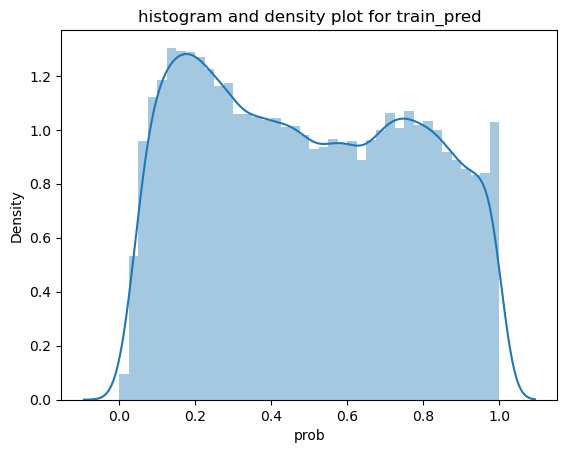

In [9]:
sns.distplot(a=train_pred.prob)
plt.title('histogram and density plot for train_pred')
print(np.mean(train_pred))

In [ ]:
train_pred

,prob
0,0.4475
1,0.2120
2,0.1895
3,0.0630
4,0.2020
...,...
64687,0.9000
64688,0.8240
64689,0.5455
64690,0.5905


In [ ]:
pred = []
for i in train_pred['prob']:
  if i >= 0.4937:
    pred.append(1),
  else:
    pred.append(0)

train_pred['pred'] = pred
train_pred

,prob,pred
0,0.4475,0
1,0.2120,0
2,0.1895,0
3,0.0630,0
4,0.2020,0
...,...,...
64687,0.9000,1
64688,0.8240,1
64689,0.5455,1
64690,0.5905,1


In [ ]:
print(metrics.classification_report(list(y_train['Outcome']), train_pred.pred))
print(metrics.balanced_accuracy_score(list(y_train['Outcome']), train_pred.pred))


              precision    recall  f1-score   support

           0       0.75      0.77      0.76     32346
           1       0.77      0.74      0.75     32346

    accuracy                           0.76     64692
   macro avg       0.76      0.76      0.76     64692
weighted avg       0.76      0.76      0.76     64692

0.7579144252766957


In [11]:
#Testing
y_pred = pd.DataFrame(posterior_predictive.predictions['likelihood'].mean(('chain', 'draw')),columns=['prob'])
y_pred['round'] = y_pred.prob.round()
y_pred

,prob,round
0,0.28900,0.0
1,0.18425,0.0
2,0.35900,0.0
3,0.60150,1.0
4,0.46900,0.0
...,...,...
71911,0.36600,0.0
71912,0.71975,1.0
71913,0.23250,0.0
71914,0.17925,0.0


In [40]:
#Validation
y_pred = pd.DataFrame(posterior_predictive_valid.predictions['likelihood'].mean(('chain', 'draw')),columns=['prob'])
y_pred['round'] = y_pred.prob.round()
y_pred

,prob,round
0,0.46325,0.0
1,0.10550,0.0
2,0.53700,1.0
3,0.16125,0.0
4,0.04525,0.0
...,...,...
11467,0.76425,1.0
11468,0.59000,1.0
11469,0.26450,0.0
11470,0.87800,1.0


0.30375


/var/folders/q3/4xkzknpn01j0stqqmhhm0jpr0000gn/T/ipykernel_28449/2205334277.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=y_pred.prob)


Text(0.5, 1.0, 'histogram and density plot for testing set')

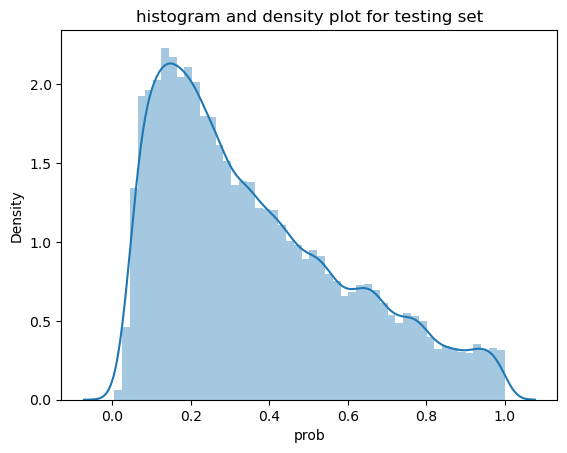

In [12]:
print(np.median(y_pred.prob))

sns.distplot(a=y_pred.prob)
plt.title('histogram and density plot for testing set')


In [13]:
print('classification report for test set')
print(metrics.classification_report(list(y_test['Outcome']), list(y_pred['round'])))
print('Balanced Accuracy Test')
print(metrics.balanced_accuracy_score(list(y_test['Outcome']), list(y_pred['round'])))


print('AUCROC Test')
print(metrics.roc_auc_score(list(y_test['Outcome']), y_pred['prob']))

classification report for test set
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     64598
           1       0.25      0.67      0.37      7318

    accuracy                           0.77     71916
   macro avg       0.60      0.72      0.61     71916
weighted avg       0.88      0.77      0.81     71916

Balanced Accuracy Test
0.723350240245047
AUCROC Test
0.8070735626828446


In [42]:
print('classification report for validation set')
print(metrics.classification_report(list(y_validation['Outcome']), list(y_pred['round'])))
print('Balanced Accuracy Test')
print(metrics.balanced_accuracy_score(list(y_validation['Outcome']), list(y_pred['round'])))


print('AUCROC Test')
print(metrics.roc_auc_score(list(y_validation['Outcome']), y_pred['prob']))

classification report for validation set
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      5697
           1       0.77      0.71      0.74      5775

    accuracy                           0.75     11472
   macro avg       0.75      0.75      0.74     11472
weighted avg       0.75      0.75      0.74     11472

Balanced Accuracy Test
0.7453474031673084
AUCROC Test
0.8254383145378406


In [ ]:
pred = []
for i in y_pred.prob:
  if i >= 0.31175:
    pred.append(1),
  else:
    pred.append(0)

y_pred['pred'] = pred
y_pred

,prob,round,pred
0,0.30725,0.0,0
1,0.19400,0.0,0
2,0.38700,0.0,1
3,0.55300,1.0,1
4,0.44450,0.0,1
...,...,...,...
71911,0.31575,0.0,1
71912,0.69925,1.0,1
71913,0.30150,0.0,0
71914,0.33575,0.0,1


In [ ]:
print(y_pred.pred.value_counts())
y_test.Outcome.value_counts()

1    35978
0    35938
Name: pred, dtype: int64


0    64598
1     7318
Name: Outcome, dtype: int64

In [ ]:
print('classification report for testing set')
print(metrics.classification_report(list(y_test['Outcome']), list(y_pred.pred)))
print(metrics.balanced_accuracy_score(list(y_test['Outcome']), list(y_pred.pred)))
print(metrics.f1_score(list(y_test['Outcome']), list(y_pred.pred)))
print(metrics.recall_score(list(y_test['Outcome']), list(y_pred.pred)))
print(metrics.precision_score(list(y_test['Outcome']), list(y_pred.pred)))

classification report for testing set
              precision    recall  f1-score   support

           0       0.98      0.54      0.70     64598
           1       0.18      0.88      0.30      7318

    accuracy                           0.58     71916
   macro avg       0.58      0.71      0.50     71916
weighted avg       0.90      0.58      0.66     71916

0.7128267948934813
0.29836474501108656
0.882618201694452
0.17952637723052978
